# Importing Necessary Packages and Configuring Input Directories

In [ ]:
import cv2
import os, sys
import numpy as np
from skimage import io, restoration
import matplotlib.pyplot as plt
from skimage.util import random_noise, img_as_float

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
adversaries_dir = '/content/drive/My Drive/Capstone 2023/Images/adversaries_7b' # path that contains adversarial images
defenses_dir = os.path.join(os.path.dirname(adversaries_dir), 'defenses_7b') # path for storaging images after applying defense
os.makedirs(defenses_dir, exist_ok=True)

# Resizing and Rescaling in OpenCV

OpenCV offers several interpolation methods for resizing images.

### Interpolation Methods

1. **`cv2.INTER_NEAREST`**:
  - Assigns the nearest pixel value to the new pixel, but may produce jagged edges.
  - Ideal for fast processing where image smoothness is not a priority.

2. **`cv2.INTER_LINEAR`**:
  - Implements bilinear interpolation using a 2x2 pixel neighborhood.
  - Provides smoother images than nearest neighbor interpolation and is suitable for general-purpose image resizing.

3. **`cv2.INTER_AREA`**:
   - Calculates the average of pixels fitting into the new pixel area.
   - Preferred for image downsampling, ensuring quality in shrunken images.

4. **`cv2.INTER_CUBIC`**:
   - Uses a 4x4 pixel neighborhood for bicubic interpolation.
   - Although slower than bilinear, it produces better results with smoother edges and curves, suitable for high-quality resizing.

   ...


In [ ]:
def resize(image, scale_factor = 0.9, interpolation = cv2.INTER_AREA):

  h, w = image.shape[:2]

  resized_image = cv2.resize(image, (int(w*scale_factor), int(h*scale_factor)), interpolation = interpolation)

  return resized_image

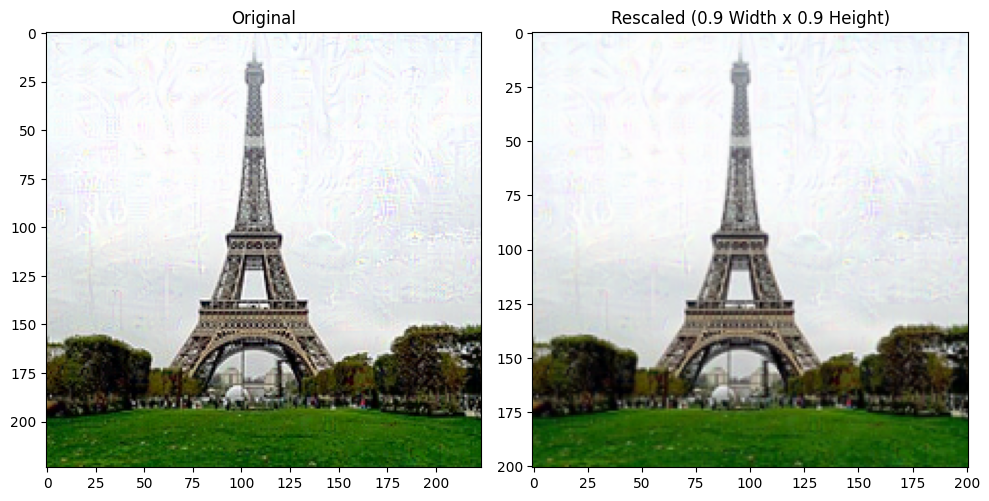

In [ ]:
shrink_factor = 0.9

for i, adversary in enumerate(os.listdir(adversaries_dir)):
  image = cv2.imread(os.path.join(adversaries_dir,adversary))

  image_resized = resize(image)
  cv2.imwrite(os.path.join(defenses_dir, adversary.split('.')[0]+'_rescaled.png'), image_resized)

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # Set a larger figure size for better visibility

    # Display the original image
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    # Display the resized image
    ax[1].imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'Rescaled ({shrink_factor} Width x {shrink_factor} Height)')

    plt.tight_layout()
    plt.show()

# Compression -- JPEG Compression

### JPEG Compression Mechanism

JPEG compression involves several steps to efficiently reduce the size of images while maintaining acceptable quality. These steps are:

1. **Color Space Conversion**:
   - The image is converted from RGB to YCbCr color space. This step leverages the human eye's greater sensitivity to brightness than to color details.

2. **Subsampling**:
   - The chrominance components (Cb and Cr) are subsampled due to the human eye's lower sensitivity to color. A common technique is 4:2:0 subsampling.

3. **Discrete Cosine Transform (DCT)**:
   - The image is divided into 8x8 pixel blocks, and DCT is applied to each block. DCT helps to categorize image parts based on their visual significance.

4. **Quantization**:
   - Post-DCT, the blocks undergo quantization, reducing data precision. This step introduces lossy compression by simplifying higher frequency components more than the lower ones.

5. **Zigzag Order**:
   - The quantized blocks are reordered in a zigzag pattern, grouping low-frequency components at the start and high-frequency ones at the end.

6. **Differential Coding**:
   - Techniques like run-length encoding (RLE) are used on the zigzag-ordered blocks. RLE is effective in representing sequences of zeros concisely.

7. **Huffman Coding**:
   - This step involves encoding the quantized data using variable-length codes, assigning shorter codes to more frequent values to optimize compression.

8. **File Formatting**:
   - Finally, the compressed data, along with headers and other necessary metadata, is compiled into the JPEG file format for storage or transmission.



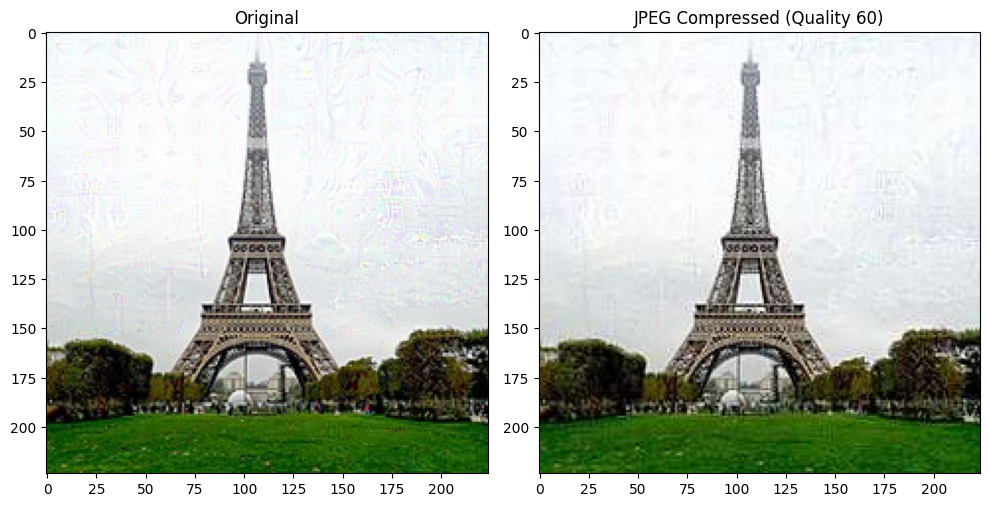

In [ ]:
quality = 60

for i, adversary in enumerate(os.listdir(adversaries_dir)):
  image = cv2.imread(os.path.join(adversaries_dir,adversary))

  image_compressed_path = os.path.join(defenses_dir, adversary.split('.')[0] +'_jpegCompressed.jpg')
  cv2.imwrite(image_compressed_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # Set a larger figure size for better visibility

    # Display the original image
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    # Display the resized image
    ax[1].imshow(cv2.cvtColor(cv2.imread(image_compressed_path), cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'JPEG Compressed (Quality {quality})')

    plt.tight_layout()
    plt.show()

# Cropping



In [ ]:
def crop(image, percent_retained = 90):

    if percent_retained <= 0 or percent_retained> 100:
        raise ValueError("Percent must be a value between 0 and 100.")

    percent_retained = percent_retained / 100
    height, width = image.shape[:2]

    new_width = int(width * percent_retained)
    new_height = int(height * percent_retained)

    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2

    image_cropped = image[top:bottom, left:right]

    return image_cropped

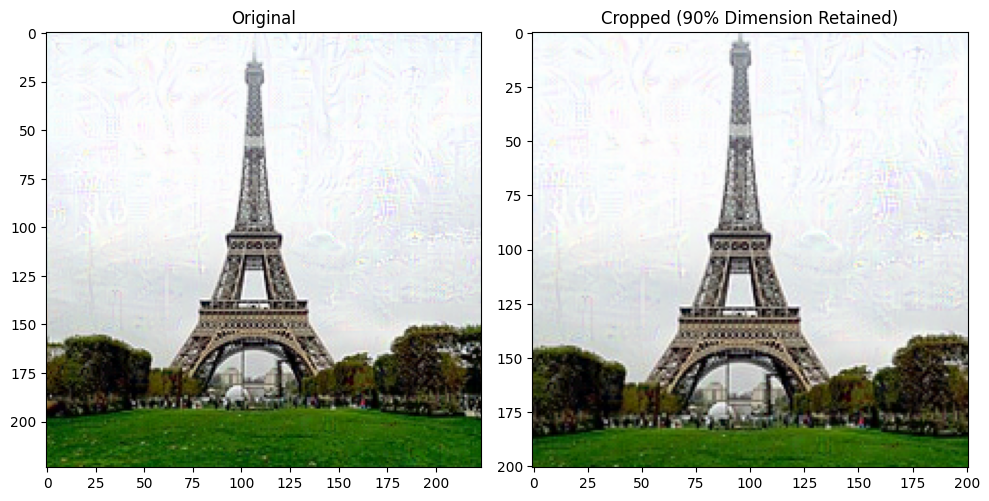

In [ ]:
percent_retained = 90

for i, adversary in enumerate(os.listdir(adversaries_dir)):
  image = cv2.imread(os.path.join(adversaries_dir,adversary))
  image_cropped = crop(image, percent_retained)

  cv2.imwrite(os.path.join(defenses_dir, adversary.split('.')[0] + '_cropped.png'),image_cropped)

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    ax[1].imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'Cropped ({percent_retained}% Dimension Retained)')

    plt.tight_layout()
    plt.show()

# Gaussian Noise

In [ ]:
'''Method 1'''

# def add_gaussian_noise(image, mean=0, sigma=0.05):

#     h, w, c = image.shape
#     noise = np.random.normal(mean, sigma, (h, w, c))

#     image_float = image.astype(np.float32) / 255.0
#     noisy_image = image_float + noise

#     noisy_image = np.clip(noisy_image, 0, 1)
#     noisy_image = (noisy_image * 255).astype('uint8')

#     return noisy_image

In [ ]:
'''Method 1'''

# Alternatively, we can use skimage to add noise

def add_gaussian_noise(image, sigma=0.05):

    # since image is read in using bgr and scikit-image is using rgb
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # scikit-image works with pixel values in [0,1]
    image_float = img_as_float(image_rgb)

    # get corrupted image
    noisy_img_float = random_noise(image_float, mode='gaussian', var=sigma**2)

    # convert back to [0,255]
    noisy_img_uint8 = (255 * noisy_img_float).astype('uint8')

    noisy_image_bgr = cv2.cvtColor(noisy_img_uint8, cv2.COLOR_RGB2BGR)

    return noisy_image_bgr


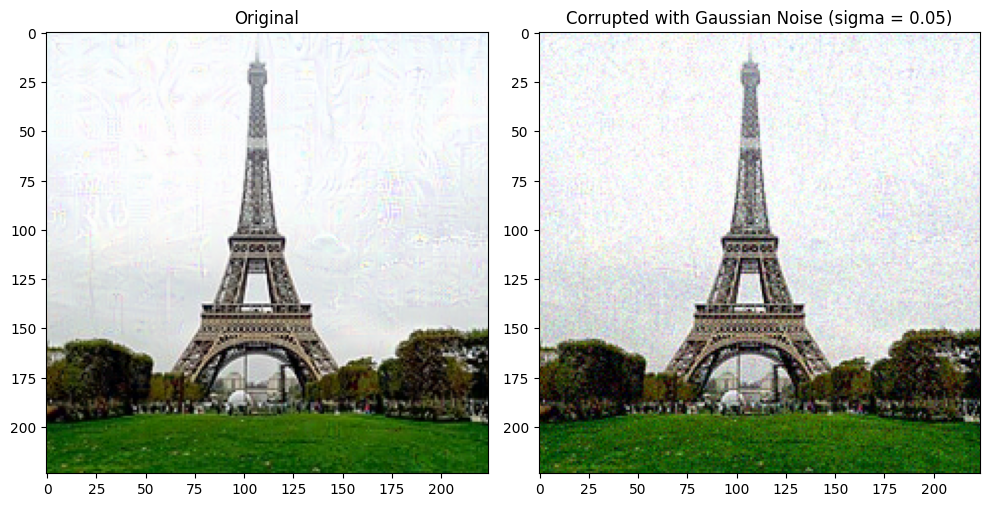

In [ ]:
sigma = 0.05

for i, adversary in enumerate(os.listdir(adversaries_dir)):

  image = cv2.imread(os.path.join(adversaries_dir,adversary))
  image_noisy = add_gaussian_noise(image)
  cv2.imwrite(os.path.join(defenses_dir,adversary.split('.')[0]+'_noisy.png'),image_noisy)

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    ax[1].imshow(cv2.cvtColor(image_noisy, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'Corrupted with Gaussian Noise (sigma = {sigma})')

    plt.tight_layout()
    plt.show()

# Bit-depth reduction

In [ ]:
def reduce_color_bit_depth(image, bit_depth=4):

    if bit_depth < 1 or bit_depth > 8:
        raise ValueError("Bit depth must be between 1 and 8.")

    scale_factor = 2 ** (8 - bit_depth)

    reduced_image = (image // scale_factor) * scale_factor
    return reduced_image

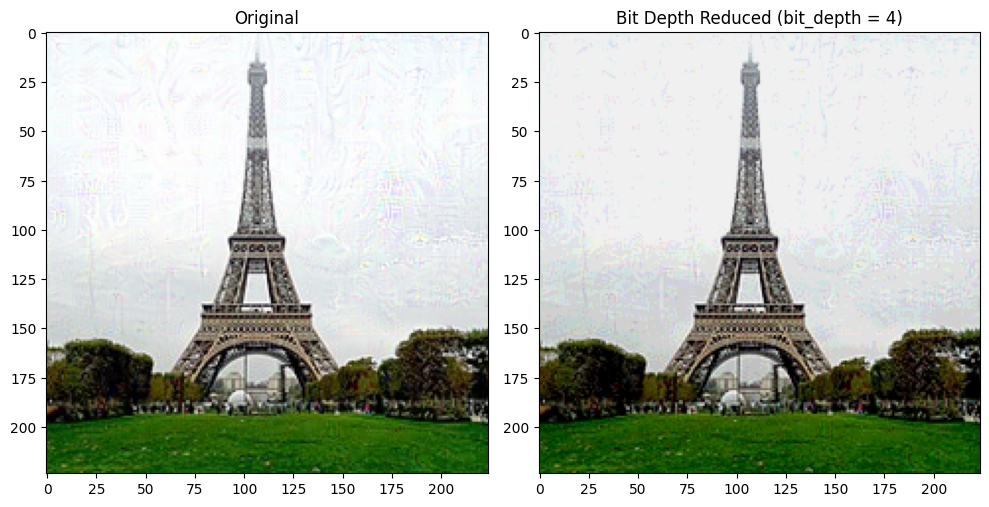

In [ ]:
bit_depth = 4 #reduce to 4 bits

for i, adversary in enumerate(os.listdir(adversaries_dir)):

  image = cv2.imread(os.path.join(adversaries_dir,adversary))
  image_bit_depth_reduced = reduce_color_bit_depth(image, bit_depth)

  cv2.imwrite(os.path.join(defenses_dir,adversary.split('.')[0] +'_bitDepthReduced.png'), image_bit_depth_reduced)

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Display the original image (need to convert to rgb for matplotlib to correctly display it)
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    # Display the resized image (need to convert to rgb for matplotlib to correctly display it)
    ax[1].imshow(cv2.cvtColor(image_bit_depth_reduced, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'Bit Depth Reduced (bit_depth = {bit_depth})')

    plt.tight_layout()
    plt.show()

# Common Denoising Techniques


### OpenCV:

1. **Gaussian Blur**:
   - `cv2.GaussianBlur()`
   - It smooths an image by averaging pixel values with a Gaussian-weighted kernel. It's useful for reducing Gaussian noise and is often used as a preprocessing step for other algorithms.

2. **Median Filtering**:
   - `cv2.medianBlur()`
   - This filter replaces each pixel's value with the median value of the intensities in the pixel's neighborhood. This method is highly effective at removing salt-and-pepper noise.

3. **Bilateral Filtering**:
   - `cv2.bilateralFilter()`
   - It is designed to reduce noise while keeping edges sharp by considering the spatial closeness of pixels and the intensity difference. It's more effective for noise removal without smoothing edges than linear filters like Gaussian.

4. **Non-Local Means Denoising**:
   - `cv2.fastNlMeansDenoising()` (for grayscale images)
   - `cv2.fastNlMeansDenoisingColored()` (for color images)
   - Non-Local Means Denoising works by comparing all patches in the image and averaging similar ones. This method can better preserve texture and detail in the image.

### scikit-image:

1. **Gaussian Filter**:
   - `skimage.filters.gaussian()`
   - Similar to OpenCV's GaussianBlur, but within the scikit-image's filters module.

2. **Wiener Filter**:
   - `skimage.restoration.wiener()`
   - It aims to minimize the overall mean square error in the process of inverse filtering and noise smoothing.

3. **Total Variation Denoising**:
- `skimage.restoration.denoise_tv_chambolle()`
- It reduces noise by minimizing the total variation of the image.
- It target at the minimization problem:

$$
\min_u \sum_{i=0}^{N-1} \left( \left| \nabla u_i \right| + \frac{\lambda}{2} (f_i - u_i)^2 \right)
$$
- **weight** : *float, optional*  
Denoising weight. It is equal to $\frac{1}{\lambda}$. Therefore, the greater the *weight*, the more denoising (at the expense of fidelity to *image*).

- **eps** : *float, optional*  
Tolerance $\epsilon > 0 $ for the stop criterion (compares to absolute value of relative difference of the cost function \( E \)): The algorithm stops when
$$
\left| E_{n-1} - E_n \right| < \epsilon \cdot E_0.
$$

4. **Wavelet Denoising**:
   - `skimage.restoration.denoise_wavelet()`
   - This function utilizes the wavelet transform for noise reduction.

5. **Bilateral Filter**:
   - `skimage.restoration.denoise_bilateral()`
   - It is a non-linear, edge-preserving, and noise-reducing smoothing filter for images.
   - sigma_color: Standard deviation for grayvalue/color distance (radiometric similarity). A larger value results in averaging of pixels with larger radiometric differences. If None, the standard deviation of image will be used.
   - sigma_spatial: Standard deviation for range distance. A larger value results in averaging of pixels with larger spatial differences.
   - This is an edge-preserving, denoising filter. It averages pixels based on their spatial closeness and radiometric similarity [1]. Spatial closeness is measured by the Gaussian function of the Euclidean distance between two pixels and a certain standard deviation (sigma_spatial). Radiometric similarity is measured by the Gaussian function of the Euclidean distance between two color values and a certain standard deviation (sigma_color). Note that, if the image is of any int dtype, image will be converted using the img_as_float function and thus the standard deviation (sigma_color) will be in range [0, 1].


6. **NL-means Denoising**:
   - `skimage.restoration.denoise_nl_means()`
   - The scikit-image implementation of the non-local means denoising algorithm.

7. **Total variation denoising using split-Bregman optimization.**:
   - `skimage.restoration.denoise_tv_bregman()`
   - Another variant of total variation denoising.

In [ ]:
def total_variation_denoising(image, weight=0.01):

    # since image is read in using bgr and scikit-image is using rgb
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # scikit-image works with pixel values in [0,1]
    image_float = img_as_float(image_rgb)

    # apply the alogrithm
    denoised_image_float = restoration.denoise_tv_chambolle(
        image_float, weight=weight, channel_axis=-1
    )

    # convert back to 255
    denoised_image_uint8 = (denoised_image_float * 255).astype(np.uint8)

    # convert back to bgr
    denoised_image_bgr = cv2.cvtColor(denoised_image_uint8, cv2.COLOR_RGB2BGR)

    return denoised_image_bgr

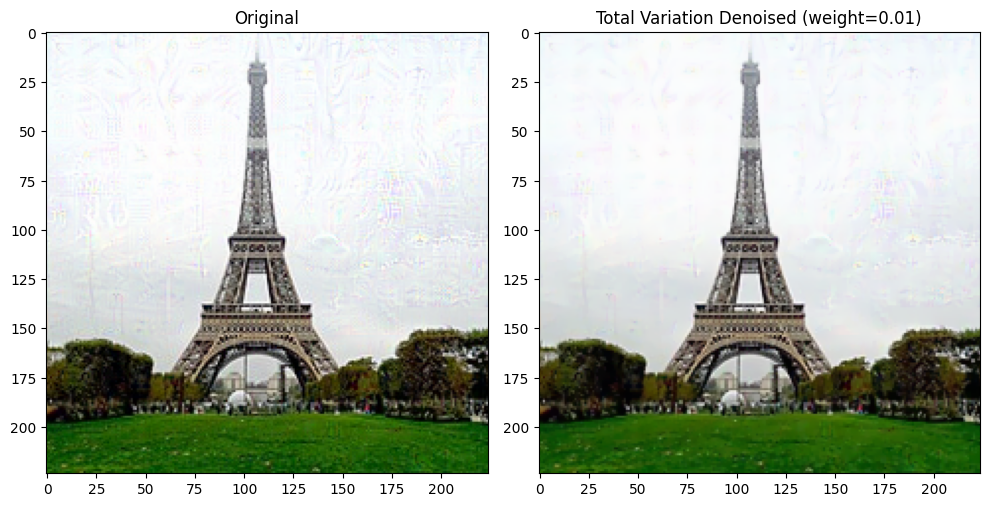

In [ ]:
weight = 0.01

for i, adversary in enumerate(os.listdir(adversaries_dir)):

  image = cv2.imread(os.path.join(adversaries_dir,adversary))
  image_denoised = total_variation_denoising(image,weight)

  cv2.imwrite(os.path.join(defenses_dir,adversary.split('.') [0] +'_tvDenoised.png'), image_denoised)

  if i == 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # Set a larger figure size for better visibility

    # display the original image (need to convert to rgb for matplotlib to correctly display it)
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original')

    # display the denoised image (need to convert to rgb for matplotlib to correctly display it)
    ax[1].imshow(cv2.cvtColor(image_denoised, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'Total Variation Denoised (weight={weight})')

    plt.tight_layout()
    plt.show()